In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from reservoirpy import mat_gen, ESN

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
def split_timeserie_for_task1(forecast, train_length=20000):

    X_train, y_train = X[:train_length], X[forecast: train_length+forecast]
    X_test, y_test = X[train_length: -forecast], X[train_length+forecast:]

    return (X_train, y_train), (X_test, y_test)

In [3]:
from reservoirpy.datasets import lorenz

timesteps = 25000
X = lorenz(timesteps)

# rescale between -1 and 1
X = 2 * (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)) - 1

In [4]:
def plot_lorenz(X, sample):

    t = np.arange(X.shape[0])
    x, y, z = X[:, 0], X[:, 1], X[:, 2]
    fig = plt.figure(figsize=(13, 5))

    plt.subplot((121))
    plt.title(f"Timeserie - {sample} timesteps")

    plt.plot(t[:sample], x[:sample], color="lightgray", zorder=0)
    plt.scatter(t[:sample], x[:sample], c=t[:sample], cmap="viridis", s=2, zorder=1)

    plt.xlabel("$t$")
    plt.ylabel("$x$")

    cbar = plt.colorbar()
    cbar.ax.set_ylabel('$t$', rotation=270)

    ax = plt.subplot((122), projection="3d")
    ax.margins(0.05)
    plt.title(f"Phase diagram: $z = f(x, y)$")
    plt.plot(x[:sample], y[:sample], z[:sample], lw=1,
             color="lightgrey", zorder=0)
    plt.scatter(x[:sample], y[:sample], zs=z[:sample],
             lw=0.5, c=t[:sample], cmap="viridis", s=2)
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    ax.set_zlabel("$z$")

    plt.tight_layout()
    plt.show()

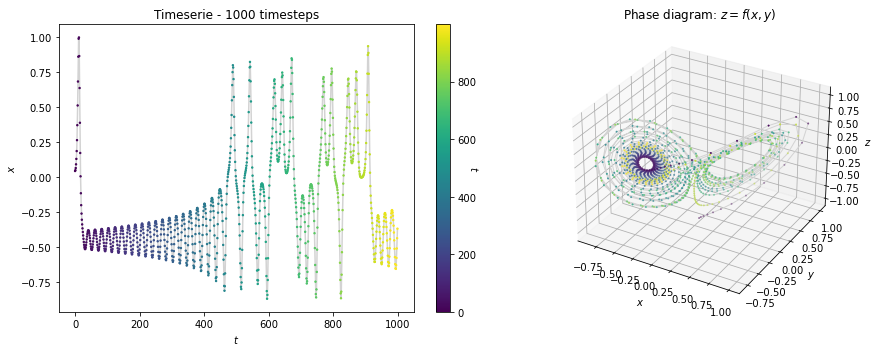

In [5]:
plot_lorenz(X, 1000)

In [7]:
units = 500
leak_rate = 0.2
spectral_radius = 1.0
input_scaling = 1.
density = 0.1
input_connectivity = 1.0
regularization = 1e-6
seed = 1234

Win = mat_gen.generate_input_weights(units, 3, input_scaling=input_scaling,
                                     proba=input_connectivity, input_bias=True,
                                     seed=seed)

W = mat_gen.generate_internal_weights(units, sr=spectral_radius,
                              proba=density, seed=seed)

reservoir = ESN(leak_rate, W, Win, ridge=regularization)

In [8]:
forecast = 1
(X_train, y_train), (X_test, y_test) = split_timeserie_for_task1(forecast)

states = reservoir.train([X_train], [y_train], verbose=True, return_states=True)

Training on 1 inputs (20000 steps) -- wash: 0 steps


Train: 100%|██████████| 20000/20000 [00:08<00:00, 2405.51it/s]


In [9]:
nb_generations = 500

# let's try another method here: we warm up the reservoir before generation with a previous state
# instead of using a sequence on warming inputs :
init_state = states[0][-1]
Xgen_test = X_test[: nb_generations]

Xgen, gen_states, _, _ = reservoir.generate(nb_generations, init_state=init_state)

In [11]:
def r2_score(y_true, y_pred):
    return 1 - (np.sum((y_true - y_pred)**2) / np.sum((y_true - y_true.mean())**2))

def nrmse(y_true, y_pred):
    return np.sqrt((np.sum(y_true - y_pred)**2) / len(y_true)) / (y_true.max() - y_true.min())

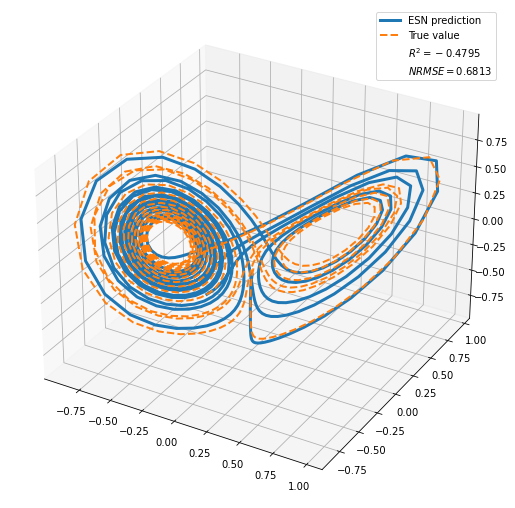

In [12]:
fig = plt.figure(figsize=(20, 20))
plt.subplot(211, projection="3d")
plt.plot(Xgen[:, 0], Xgen[:, 1], Xgen[:, 2], lw=3, label="ESN prediction")
plt.plot(Xgen_test[:, 0], Xgen_test[:, 1], Xgen_test[:, 2], linestyle="--", lw=2, label="True value")
plt.plot([], [], ' ', label=f"$R^2 = {round(r2_score(Xgen_test, Xgen), 4)}$")
plt.plot([], [], ' ', label=f"$NRMSE = {round(nrmse(Xgen_test, Xgen), 4)}$")
plt.legend(); plt.show()